In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd

In [4]:
df = pd.read_csv("/content/drive/My Drive/DV_Spot_assessment_16PD14_Kamali_s/APJ_Sir_Speech.xlsx.csv")
# Abbreviations data created manually for better cleaning
abb_df = pd.read_csv("/content/drive/My Drive/DV_Spot_assessment_16PD14_Kamali_s/abbreviations_data.csv")
# Similarly stop words data created manually
stop_df = pd.read_excel("/content/drive/My Drive/DV_Spot_assessment_16PD14_Kamali_s/my_stopwords.xlsx") 

# New Section

In [5]:
df.head()

,Id,content
0,1,"Friends, I am delighted to address you all, in..."
1,2,While there were many significant events durin...
2,3,"Friends, I recall my visit to Nagaland on 26th..."
3,4,Now I would like to talk about the initiative ...
4,5,"Let me now share with you, the enriching exper..."


Data Preprocessing

In [6]:
# Converting Stopwords of type Dataframe into list type
S = stop_df['stopwords'].to_list()
# set is used for extracting the unqiue words (since it is created manually)
StopWords = list(set(S))

In [7]:
stopwords = set(S)

In [8]:
# Data created for Replacing the contractions
contractions_dict = {
    "what's":"what is",
    "what're":"what are",
    "who's":"who is",
    "who're":"who are",
    "where's":"where is",
    "where're":"where are",
    "when's":"when is",
    "when're":"when are",
    "how's":"how is",
    "how're":"how are",

    "i'm":"i am",
    "we're":"we are",
    "you're":"you are",
    "they're":"they are",
    "it's":"it is",
    "he's":"he is",
    "she's":"she is",
    "that's":"that is",
    "there's":"there is",
    "there're":"there are",

    "i've":"i have",
    "we've":"we have",
    "you've":"you have",
    "they've":"they have",
    "who've":"who have",
    "would've":"would have",
    "not've":"not have",

    "i'll":"i will",
    "we'll":"we will",
    "you'll":"you will",
    "he'll":"he will",
    "she'll":"she will",
    "it'll":"it will",
    "they'll":"they will",

    "isn't":"is not",
    "wasn't":"was not",
    "aren't":"are not",
    "weren't":"were not",
    "can't":"can not",
    "couldn't":"could not",
    "don't":"do not",
    "didn't":"did not",
    "shouldn't":"should not",
    "wouldn't":"would not",
    "doesn't":"does not",
    "haven't":"have not",
    "hasn't":"has not",
    "hadn't":"had not",
    "won't":"will not"
}

In [9]:
# Creating symbols dictionary
symbol_dict = {
    "$":" dollar",
    "%":" percent",
    "#":" hashtag",
    "&":" and",
    "@":" at",
    "w/o":" without",
    "w/":" with"
}

In [10]:
# Similar to the conversion of stopwords, we convert abbreviations data of type Dataframe into a dictionary to reduce
# the lines of code
abbr_dict = abb_df.set_index('abbreviation').to_dict('dict')

In [11]:
from collections import Counter
import re
def words(text): return re.findall(r'\w+', text.lower())

WORDS = Counter(words(open('/content/drive/My Drive/DV_Spot_assessment_16PD14_Kamali_s/big.txt').read()))

def P(word, N=sum(WORDS.values())): 
    "Probability of `word`."
    return WORDS[word] / N

def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))


In [12]:
df.columns = ['id', 'content']

In [13]:
def DataCleaning(df, StopWords, contractions_dict, symbol_dict):
    # converting strings to lowercase
    df.content.replace(to_replace='[^a-zA-Z]', value = " ", inplace=True, regex=True) 
    
    # removing words having len <=2
    df.content.replace(to_replace=r'\b\w{1,3}\b', value = "", inplace=True, regex=True) 
    
    # Remove punctuations
    df['content'] = df['content'].str.replace('[^\w\s]','')
    
    # Removing Stopwords
    df['content'] = df['content'].apply(lambda x: " ".join(x for x in x.split() if x not in StopWords))
    
    # Replacing contractions 
    df.content.replace(contractions_dict, regex=True,inplace=True)
    
    # Replacing symbols
    df.content.replace(symbol_dict,regex=True,inplace=True)
    
    return df

In [14]:
df = DataCleaning(df, StopWords, contractions_dict, symbol_dict)

In [27]:
# These are in-built libraries for doing the lemmatization since manual work is tedious for lemmatizing
import spacy
nlp = spacy.load('en', disable=['parser', 'ner'])

from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [28]:
# Using the correction function which is being trained by my model 
# Doing spelling correction and lemmatization only for adjectives, verbs and adverbs, not for nouns
# I make the correction first and then I lemmatize
# it takes some time to run 
def NextLevelCleaning(df):
    for i in range(df.shape[0]):
        words_notin_stopwords = []
        # Tagging each word with their grammar meaning
        doc = nlp(df.iloc[i,1])
        for token in doc:
            if token.pos_ == 'ADJ':
                x = correction(str(token))
                words_notin_stopwords.append(lemmatizer.lemmatize(x, pos='a'))
            if token.pos_ == 'VERB':
                x = correction(str(token))
                words_notin_stopwords.append(lemmatizer.lemmatize(x, pos='v'))
            if token.pos_ == 'ADV':
                x = correction(str(token))
                words_notin_stopwords.append(lemmatizer.lemmatize(x, pos='r'))
        df.iloc[i,1] = ' '.join(words_notin_stopwords)
    return df

In [29]:
df = NextLevelCleaning(df)

In [30]:
import nltk 
from nltk.corpus import wordnet 

In [31]:
# Finding Semantic Similarity for words that are not nouns
def Find_And_Replace_Related_Words(df):
    similar_words = {}
    for i in range(df.shape[0]):
        words = df.iloc[i,1].split()
        for key in words:
            syn_names = []
            for syn in wordnet.synsets(key):
                if syn.name().split(".")[0] not in syn_names:
                    syn_names.append(syn.name().split(".")[0])
            if key in syn_names:
                syn_names.remove(key)
            key = key + " "
            similar_words[key] = tuple(syn_names)
    # Converting dict into a dataframe
    synonyms_df = pd.DataFrame(list(similar_words.items()), columns=['key', 'synonyms'])
    new_dict = dict(zip(similar_words.values(),similar_words.keys()))
    
    # New_dict: {'paper','school','college','exams'} : "education"
    # Convert into: {'paper'} : 'education'
    #               {'school'} : 'education'
    #               {'college'} : 'education'
    #               {'exams'} : 'education'
    final_df = pd.DataFrame(columns = ['Find','Replace'] )
    for key in new_dict.keys():
        d = pd.DataFrame({"Find":["he"],"Replace":["she"]})
        if key:
            for j in key:
                d.iloc[0,0] = j
                d.iloc[0,1] = new_dict[key]
                find = final_df.Find.to_list()
                if d.iloc[0,0] not in find:
                    final_df = final_df.append(d)
                    
    # Finding and Replacing in my actual data
    for i in range(df.shape[0]):
        words = df.iloc[i,1].split()
        clean_words = []
        for word in words:
            for j in range(final_df.shape[0]):
                if word == final_df.iloc[j,0]:
                    clean_words.append(final_df.iloc[j,1])
                    break
                else:
                    clean_words.append(word)
                    break
        df.iloc[i,1] = " ".join(list(set(clean_words)))
        
    return df

In [32]:
df = Find_And_Replace_Related_Words(df)

In [33]:
# Cleaned data
df.head()

,id,content
0,1,enjoy live wonderful work abroad message compl...
1,2,develop echo safe appreciate reflect visit ask...
2,3,Nagaland villages enable connect discuss uniqu...
3,4,active large sustainable support work technolo...
4,5,protect evince wait fertile agricultural Horti...


In [34]:
from collections import Counter

In [35]:
content = []
for i in df.content.values:
    for j in i.split():
        content.append(j)

In [36]:
content_list = content

In [37]:
words = Counter(content)

Question 1

In [38]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.image as mpimg
import cv2
from PIL import Image
import matplotlib.pyplot as plt

In [39]:
content = " ".join(content)

(-0.5, 479.5, 359.5, -0.5)

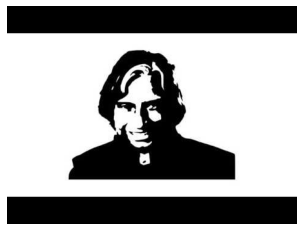

In [40]:
im = Image.open('/content/drive/My Drive/DV_Spot_assessment_16PD14_Kamali_s/APJ2.jpg')
plt.imshow(im)
plt.axis("off")

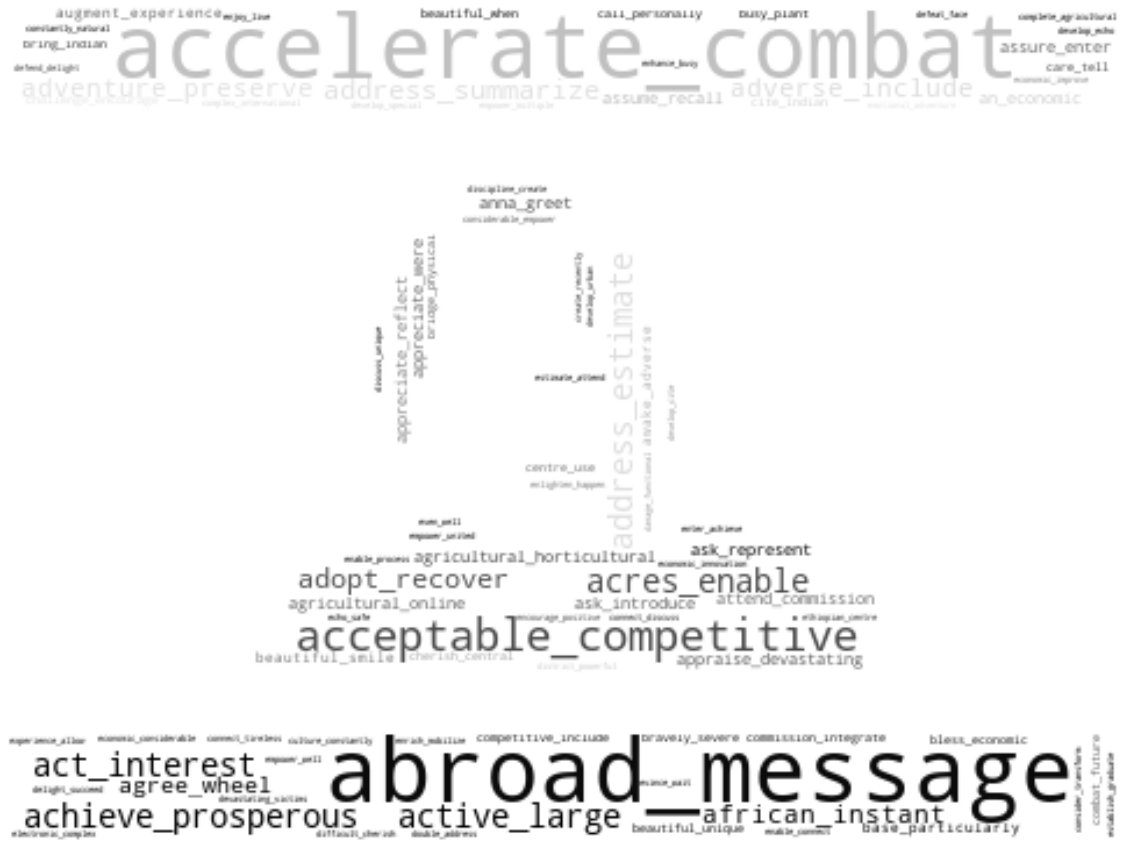

In [87]:
im = Image.open('/content/drive/My Drive/DV_Spot_assessment_16PD14_Kamali_s/APJ2.jpg')
width, height = im.size

img = mpimg.imread('/content/drive/My Drive/DV_Spot_assessment_16PD14_Kamali_s/APJ2.jpg')
comments_text = content
# Generate a word cloud image
mask = img
wordcloud_usa = WordCloud(width=width, height=height, stopwords=stopwords,
                          background_color="white", mode="RGBA", max_words=10000, mask=img).generate_from_frequencies(words)
# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[20,20])
plt.imshow(wordcloud_usa.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")

plt.show()

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [43]:
vectorizer = TfidfVectorizer(ngram_range = (2, 2)) 
X2 = vectorizer.fit_transform(df['content']) 

In [44]:
scores = (X2.toarray()) 
features = (vectorizer.get_feature_names()) 
# Getting top ranking features 
sums = X2.sum(axis = 0) 
data1 = [] 
for col, term in enumerate(features): 
    data1.append( (term, sums[0, col] )) 
bigram_df = pd.DataFrame(data1, columns = ['term', 'rank']) 

In [45]:
bigram_df.head()

,term,rank
0,abroad message,0.192450
1,accelerate combat,0.192450
2,acceptable competitive,0.160128
3,achieve prosperous,0.250000
4,acres enable,0.160128


In [46]:
bigram_df.term.replace(to_replace=' ', value = "_", inplace=True, regex=True) 

In [47]:
bigram_df.head()

,term,rank
0,abroad_message,0.192450
1,accelerate_combat,0.192450
2,acceptable_competitive,0.160128
3,achieve_prosperous,0.250000
4,acres_enable,0.160128


In [48]:
words = Counter(bigram_df.term.values)

In [49]:
bigram_content = []
for i in bigram_df.term.values:
    bigram_content.append(i)
bigram_content = " ".join(bigram_content)

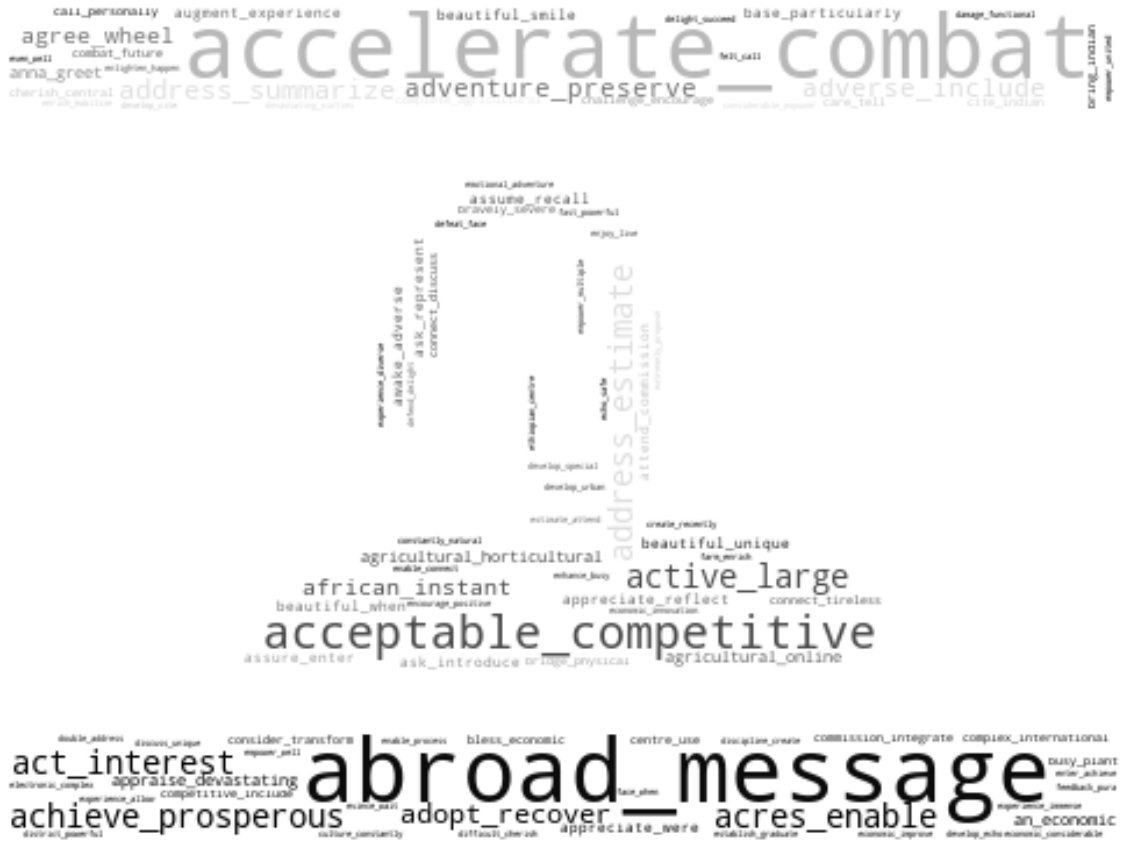

In [50]:
im = Image.open('/content/drive/My Drive/DV_Spot_assessment_16PD14_Kamali_s/APJ2.jpg')
width, height = im.size

img = mpimg.imread('/content/drive/My Drive/DV_Spot_assessment_16PD14_Kamali_s/APJ2.jpg')
comments_text = bigram_content
# Generate a word cloud image
mask = img
wordcloud_usa = WordCloud(width=width, height=height, stopwords=stopwords,
                          background_color="white", mode="RGBA", max_words=10000, mask=img).generate_from_frequencies(words)
# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[20,20])
plt.imshow(wordcloud_usa.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")

plt.show()

Question 2

In [51]:
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip
!pip install pyproj==1.9.6

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  libgdal-doc
The following NEW packages will be installed:
  libgeos-dev
0 upgraded, 1 newly installed, 0 to remove and 11 not upgraded.
Need to get 73.1 kB of archives.
After this operation, 486 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libgeos-dev amd64 3.6.2-1build2 [73.1 kB]
Fetched 73.1 kB in 1s (56.1 kB/s)
Selecting previously unselected package libgeos-dev.
(Reading database ... 144628 files and directories currently installed.)
Preparing to unpack .../libgeos-dev_3.6.2-1build2_amd64.deb ...
Unpacking libgeos-dev (3.6.2-1build2) ...
Setting up libgeos-dev (3.6.2-1

     |████████████████████████████████| 2.8MB 2.8MB/s 
  Created wheel for pyproj: filename=pyproj-1.9.6-cp36-cp36m-linux_x86_64.whl size=3702128 sha256=8f9fef8815e86bd34dd3dd248250bc294bd43230e6513e0cbf12c02b0c88e832
  Stored in directory: /root/.cache/pip/wheels/02/cd/b1/a2d6430f74c7a778a43d62f78bec109ca69c732dc9b929142a
Successfully built pyproj
  Found existing installation: pyproj 3.0.0.post1
    Uninstalling pyproj-3.0.0.post1:
      Successfully uninstalled pyproj-3.0.0.post1


In [88]:
import networkx as nx

In [98]:
g = nx.read_edgelist(
    "/content/drive/My Drive/DV_Spot_assessment_16PD14_Kamali_s/CollegeMsg.txt", 
    create_using=nx.DiGraph(),
    nodetype=int,
    data=(('weight',float),))

(-1.2027973371744156,
 1.1908057171106339,
 -1.1848691910505296,
 1.2076119393110276)

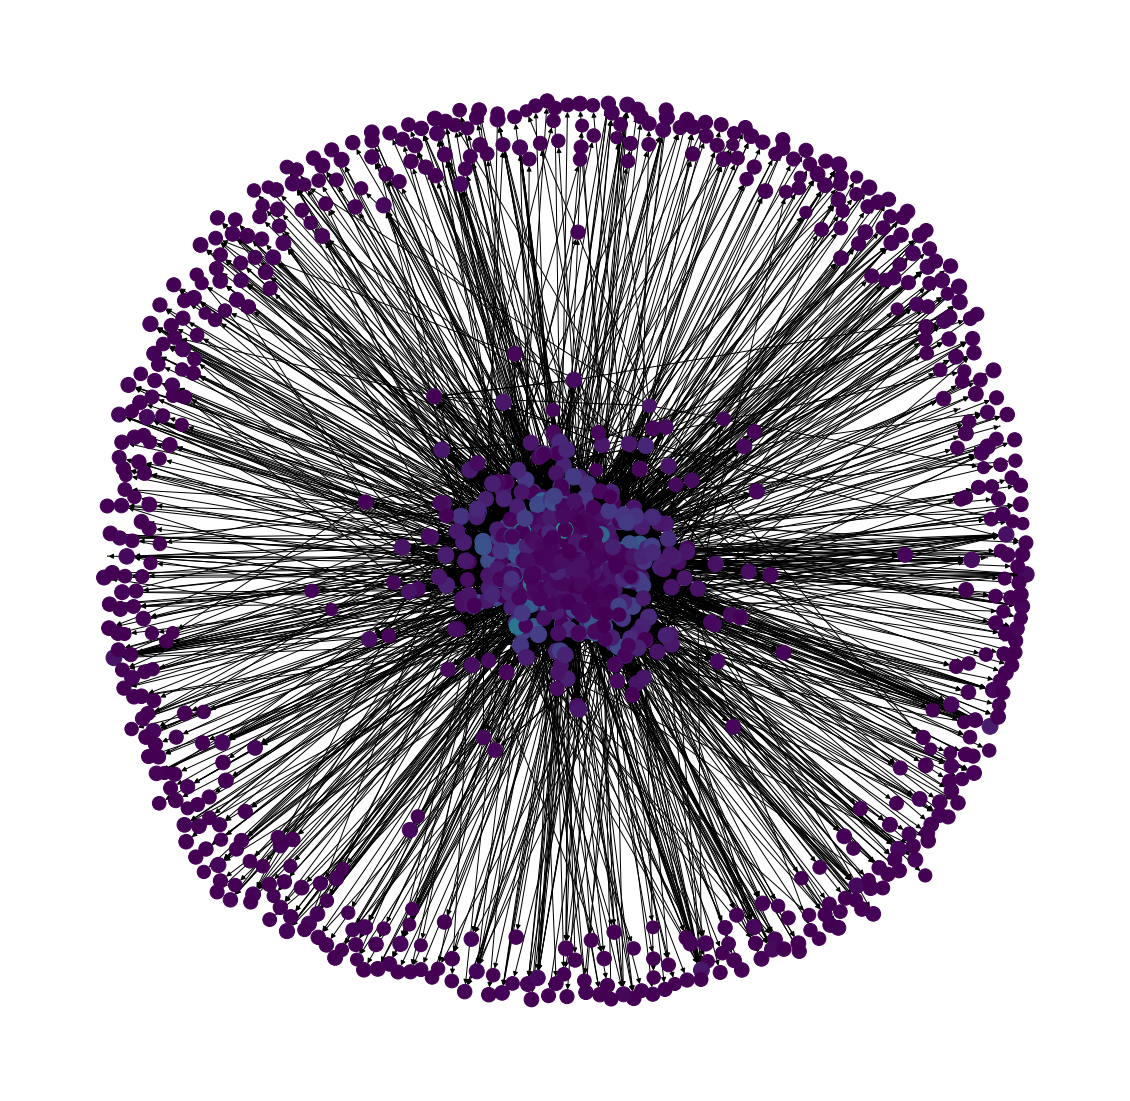

In [101]:
betCent = nx.closeness_centrality(g)
node_color = [20000.0 * g.degree(v) for v in g]
node_size =  [v * 1000 for v in betCent.values()]
plt.figure(figsize=(20,20))
nx.draw_networkx(g, with_labels=False,
                 node_color=node_color,
                 node_size=node_size )
plt.axis('off')

Visualize the airports connectivity over the world map layer

In [54]:
from mpl_toolkits.basemap import Basemap as Basemap
import matplotlib.lines as mlines
from scipy.spatial.distance import squareform, pdist
import math

In [83]:
def Question2(airport_df, routes_df):
      airport_us = airport_df[(airport_df.Country == "India")]
      us_airport_ix = airport_us.index.values
      routes_us = routes_df[(routes_df['Source Airport ID'].isin(us_airport_ix)) &
                            (routes_df['Dest Airport ID'].isin(us_airport_ix))] #extract routes that flyies from AND to USA
      routes_us =  pd.DataFrame(routes_us.groupby(['Source Airport', 'Dest Airport']).size().reset_index(name='counts'))
      counts = routes_us['Source Airport'].append(routes_us.loc[routes_us['Source Airport'] != routes_us['Dest Airport'], 'Dest Airport']).value_counts()
      counts = pd.DataFrame({'IATA': counts.index, 'total_flight': counts})
      pos_data = counts.merge(airport_us, on = 'IATA')

      # Create graph
      graph = nx.from_pandas_edgelist(routes_us, source = 'Source Airport', target = 'Dest Airport',
                              edge_attr = 'counts',create_using = nx.DiGraph())

      # Set up base map
      plt.figure(figsize=(10,15))
      m = Basemap(
              projection='merc',
              llcrnrlat=0,urcrnrlat=40,llcrnrlon=60,urcrnrlon=95,
              lat_ts=0,
              resolution='c')

      m.drawcountries(linewidth = 2)
      m.drawstates(linewidth=3)
      m.drawcoastlines(linewidth=1)
      m.fillcontinents(alpha = 0.5)

      m.readshapefile("/content/drive/My Drive/DV_Spot_assessment_16PD14_Kamali_s/IND_adm1",'Watersheds')
  # import long lat as m attribute
      mx, my = m(pos_data['Long'].values, pos_data['Lat'].values)
      pos = {}
      for count, elem in enumerate (pos_data['IATA']):
          pos[elem] = (mx[count], my[count])

      # draw nodes and edges and overly on basemap
      nx.draw_networkx_nodes(G = graph, pos = pos, nodelist = [x for x in graph.nodes() if counts['total_flight'][x] >= 50],
                              node_color = 'r', alpha = 0.8,
                              node_size = [counts['total_flight'][x]*4  for x in graph.nodes() if counts['total_flight'][x] >= 50])

      nx.draw_networkx_labels(G = graph, pos = pos, font_size=10,
                              labels = {x:x for x in graph.nodes() if counts['total_flight'][x] >= 50})

      nx.draw_networkx_nodes(G = graph, pos = pos, nodelist = [x for x in graph.nodes() if counts['total_flight'][x] < 50],
                              node_color = 'b', alpha = 0.6,
                              node_size = [counts['total_flight'][x]*4  for x in graph.nodes() if counts['total_flight'][x] < 50])

      nx.draw_networkx_edges(G = graph, pos = pos, edge_color = 'g', width = routes_us['counts']*0.75, 
                              alpha=0.06, arrows = False)

      line1 = mlines.Line2D(range(1), range(1), color="white", marker='o', markerfacecolor="yellow")
      line2 = mlines.Line2D(range(1), range(1), color="white", marker='o',markerfacecolor="purple")
      line3 = mlines.Line2D(range(1), range(1), color="green", marker='',markerfacecolor="magenta")
      plt.legend((line1, line2, line3), ('Large Airports', 'Smaller airports', 'Route'),
                  loc=4, fontsize = 'x-large')
      plt.title("Airports connectivity over the world map layer", fontsize = 20)
      #m.bluemarble()
      plt.tight_layout()
      #plt.savefig("./images/networkx_basemap/map_3.png", format = "png", dpi = 300)
      plt.show()
      return

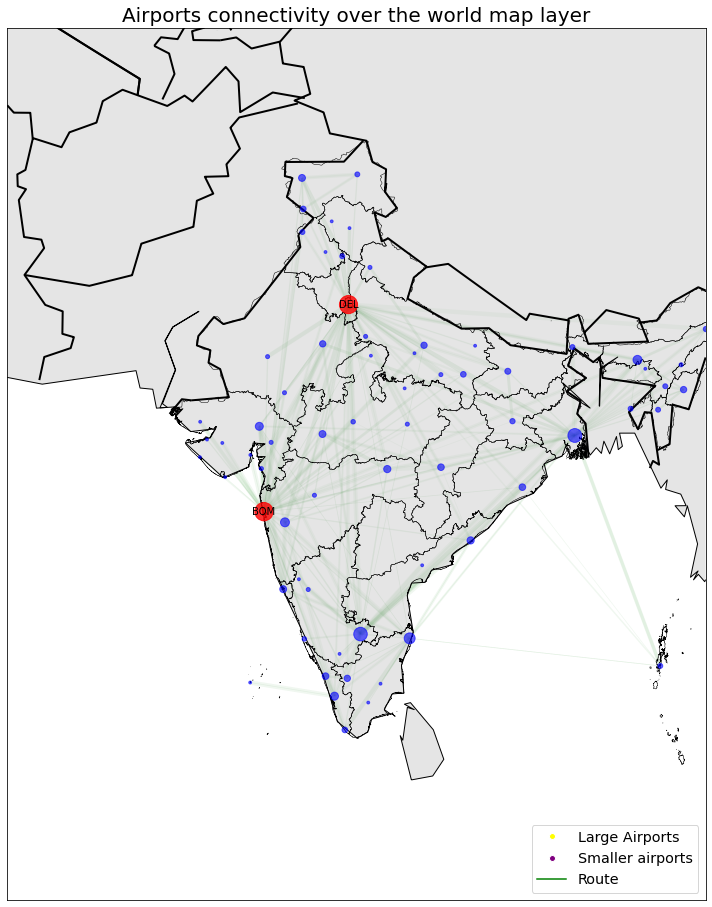

In [84]:
# Airport data
airport_col = ['ID', 'Name', 'City', 'Country','IATA', 'ICAO', 'Lat', 'Long', 'Alt', 'Timezone', 'DST', 'Tz database time zone', 'type', 'source']
airport_df = pd.read_csv("https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat",names = airport_col, index_col = 0)

# routes Data
route_cols = ['Airline', 'Airline ID', 'Source Airport', 'Source Airport ID','Dest Airport', 'Dest Airport ID', 'Codeshare', 'Stops', 'equipment']
routes_df = pd.read_csv("https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat",names = route_cols)

routes_df['Source Airport ID'] = pd.to_numeric(routes_df['Source Airport ID'].astype(str), 'coerce')
routes_df['Dest Airport ID'] = pd.to_numeric(routes_df['Dest Airport ID'].astype(str), 'coerce')
routes_df = routes_df.dropna(subset=["Source Airport ID", "Dest Airport ID"]) 

Question2(airport_df, routes_df)

In [66]:
!pip install --upgrade plotly

     |████████████████████████████████| 13.1MB 264kB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


Question 3

In [67]:
import urllib
import plotly.express as px

In [85]:
world_data = pd.read_csv("/content/drive/My Drive/DV_Spot_assessment_16PD14_Kamali_s/world_countries_dataset.csv")

In [86]:
fig = px.treemap(world_data,
                 path=['Region', 'Country'],
                 values='Population',
                 color='GDP ($ per capita)',
                 color_continuous_scale='rainbow',
                 width=1000, height=600,
                 title="GDP of Indian states (2020)",)

fig.show()